# Plotting for the paper

Code to make plots and do some basic analysis for the paper

In [27]:
# imports
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.time import Time

In [28]:
data = pd.read_csv("reduced-photometry.csv")
keys_to_keep = {
    "FILTER" : "Filter",
    "aperture_sum" : "Source Aperture Sum (ADU)",
    "aperture_sum_e" : "Source Aperture Sum (e)",
    "aperture_sum_photons" : "Source Aperture Sum ($\gamma$)",
    "bckgd_adu" : "Background Annulus Sum (ADU)",
    "bckgd_e" : "Background Annulus Sum (e)",
    "bckgd_photons" : "Background Annulus Sum ($\gamma$)",
    "dark_noise_adu" : "Dark Noise ($\sigma_D$; ADU/pixel)",
    "dark_noise_e" : "Dark Noise ($\sigma_D$; e/pixel)",
    "read_noise_adu": "Read Noise ($\sigma_R$; ADU/pixel)",
    "read_noise_e" : "Read Noise ($\sigma_R$; e/pixel)",
    "signal_e" : "Signal ($f_e$; e)",
    "signal_photons" : "Signal ($f_\gamma$; $\gamma$)",
    "SNR" : "SNR",
    "zero_point" : "Zero Point ($10^{12}f_0$; $\gamma$)",
    "mag" : "Apparent Magnitude",
    "mag_err" : "Apparent Magnitude Error"
}

data1 = data.rename(mapper=keys_to_keep, axis=1)
data1[keys_to_keep["zero_point"]] = data1[keys_to_keep["zero_point"]] / 1e12

for_tex = data1[list(keys_to_keep.values())].T
for_tex.columns = for_tex.loc["Filter"]
for_tex = for_tex.drop("Filter")

# Use the Styler object to format the output
styler = for_tex.style.format(formatter='{:.2f}'.format)

print(styler.to_latex(label="tab:res", caption="Reduction Results"))

\begin{table}
\caption{Reduction Results}
\label{tab:res}
\begin{tabular}{lllll}
Filter & Harris-V & Bessell-U & Harris-B & Harris-R \\
Source Aperture Sum (ADU) & 525131.38 & 95118.46 & 352222.45 & 554880.18 \\
Source Aperture Sum (e) & 1627907.28 & 294867.23 & 1091889.60 & 1720128.57 \\
Source Aperture Sum ($\gamma$) & 2711100.28 & 491068.91 & 1818421.88 & 2864684.69 \\
Background Annulus Sum (ADU) & 521430.41 & 94325.44 & 348674.99 & 549048.02 \\
Background Annulus Sum (e) & 1616434.28 & 292408.86 & 1080892.45 & 1702048.85 \\
Background Annulus Sum ($\gamma$) & 2691993.26 & 486974.75 & 1800107.34 & 2834574.90 \\
Dark Noise ($\sigma_D$; ADU/pixel) & 0.29 & 0.29 & 0.29 & 0.29 \\
Dark Noise ($\sigma_D$; e/pixel) & 0.51 & 0.51 & 0.51 & 0.51 \\
Read Noise ($\sigma_R$; ADU/pixel) & 3.26 & 3.26 & 3.26 & 3.26 \\
Read Noise ($\sigma_R$; e/pixel) & 10.10 & 10.10 & 10.10 & 10.10 \\
Signal ($f_e$; e) & 11473.00 & 2458.37 & 10997.15 & 18079.72 \\
Signal ($f_\gamma$; $\gamma$) & 19107.02 & 4094.1

# Plot the measured magnitudes

with some other data taken from TNS

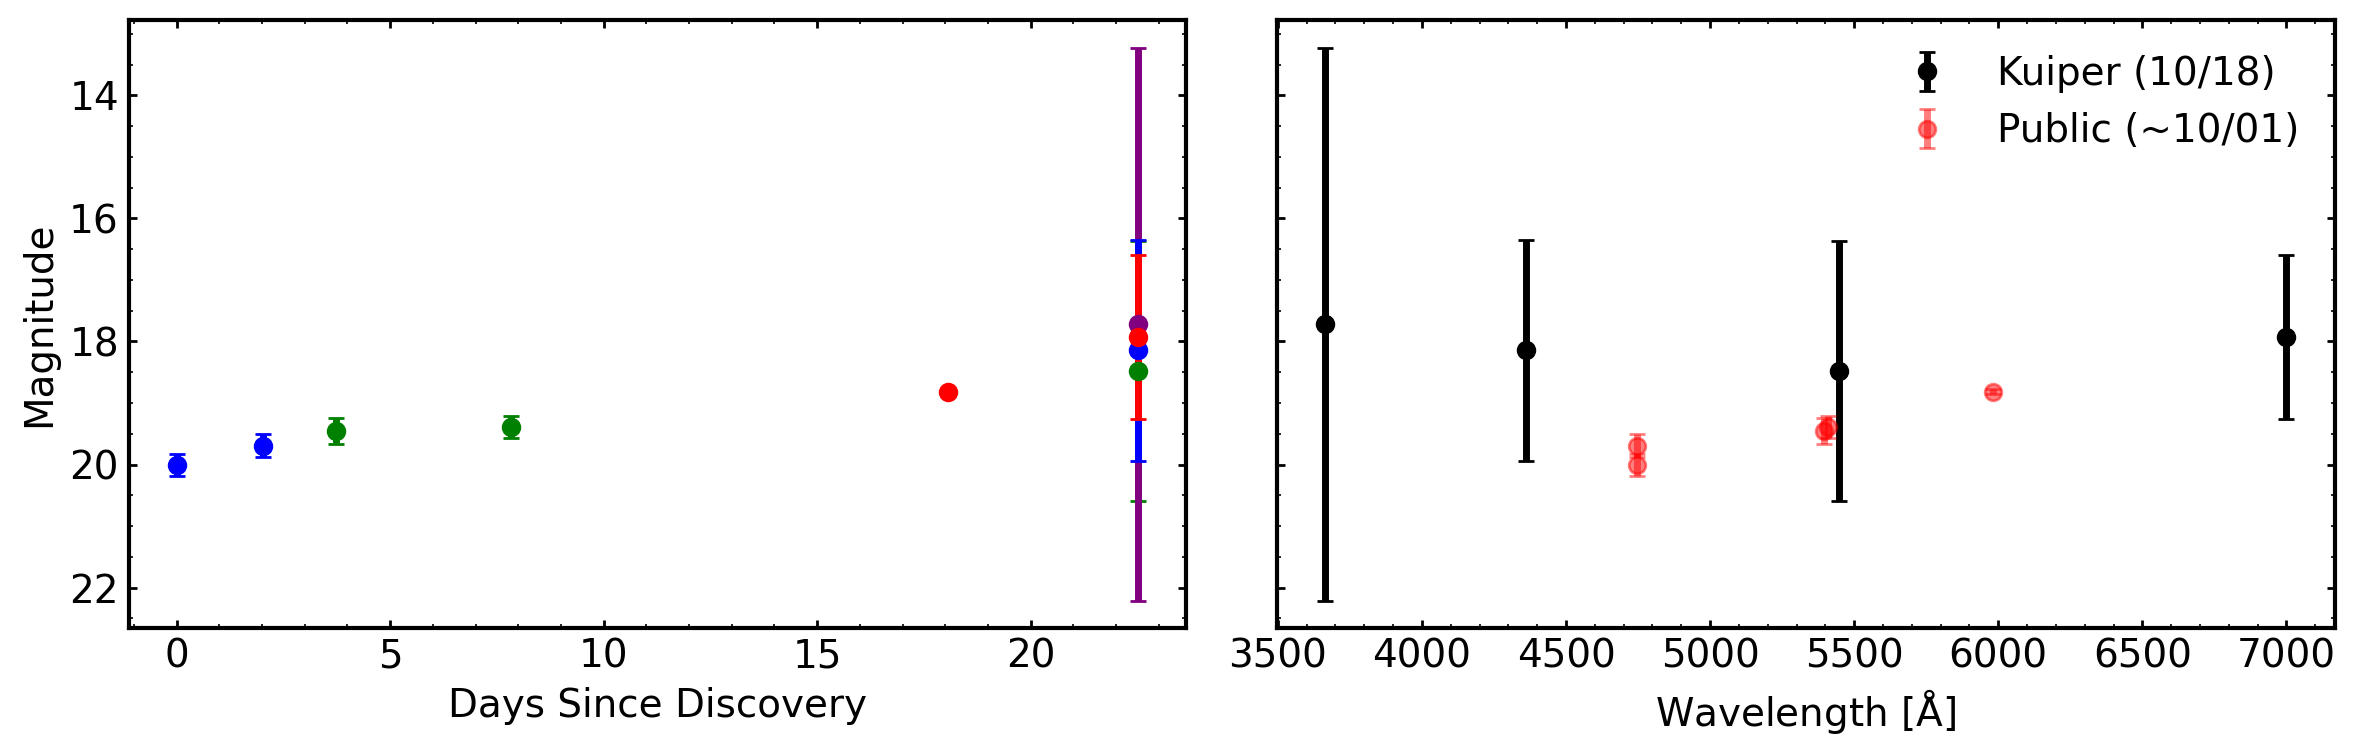

In [41]:
filter_wavelengths = {
    "Harris-V" : 5448, # angstroms
    "Bessell-U": 3663,
    "Harris-B" : 4361,
    "Harris-R" : 7000
}

tns_factor = 1e14
filter_zps = {
    "Harris-V" : 363.1e-11*tns_factor, # erg cm**-2 s**-1 A**-1
    "Bessell-U": 417.5e-11*tns_factor,
    "Harris-B" : 632e-11*tns_factor,
    "Harris-R" : 217.7e-11*tns_factor
}

color_map = {
    "Harris-V" : "g", # angstroms
    "Bessell-U": "purple",
    "Harris-B" : "b",
    "Harris-R" : "r"
}

data["wave"] = [filter_wavelengths[f] for f in data.FILTER]

fig, (ax, ax2) = plt.subplots(1,2,figsize=(12,4),sharey=True)

#spec = pd.read_csv("tns_2024wsd_2024-10-13_P200_DBSP_ZTF.txt", sep=' ')
#ax.plot(spec.wl, spec.flux/1e2)

public_phot = pd.DataFrame(dict(
    mag = [18.82, 19.696, 20.0047, 19.46, 19.387],
    mag_err = [0.04, 0.186, 0.181, 0.21, 0.174],
    wave = [5980.70, 4746.48, 4746.48, 5396.65, 5408.724658332794],
    date = [
        Time("2024-10-13 13:03:26", format="iso").mjd,
        Time("2024-09-27 12:15:26", format="iso").mjd,
        Time("2024-09-25 11:27:40", format="iso").mjd,
        Time("2024-09-29 05:01:11", format="iso").mjd,
        Time("2024-10-03 07:32:09", format="iso").mjd
    ],
    color = ["r", "b", "b", "g", "g"]
))

# plot the SED
ax2.errorbar(data.wave, data.mag, yerr=data.mag_err, color='k', marker='o', linestyle='none', label="Kuiper (10/18)")
ax2.errorbar(public_phot.wave, public_phot.mag, yerr=public_phot.mag_err, color='r', alpha=0.5, marker='o', linestyle='none', label="Public (~10/01)")

ax.invert_yaxis()

ax2.legend()

# plot the light curve
ddate = Time("2024-09-25 11:27:40.000", format="iso").mjd
for c, grp in public_phot.groupby("color"):
    ax.errorbar(grp.date-ddate, grp.mag, yerr=grp.mag_err, color=c, marker='o', linestyle='none')

obsdate = Time("2024-10-18", format='iso').mjd
for _,row in data.iterrows():
    ax.errorbar(obsdate-ddate, row.mag, row.mag_err, color=color_map[row.FILTER], marker='o', linestyle='none')

ax.set_xlabel("Days Since Discovery")
ax2.set_xlabel(r"Wavelength [$\AA$]")
ax.set_ylabel("Magnitude")

fig.savefig("sed_lc.png")